# Student-t Process

PyMC3 also includes T-process priors.  They are a generalization of a Gaussian process prior to the multivariate Student's T distribution.  The usage is identical to that of `gp.Latent`, except they require a degrees of freedom parameter when they are specified in the model.  For more information, see chapter 9 of [Rasmussen+Williams](http://www.gaussianprocess.org/gpml/), and [Shah et al.](https://arxiv.org/abs/1402.4306).

Note that T processes aren't additive in the same way as GPs, so addition of `TP` objects are not supported.

## Samples from a TP prior

The following code draws samples from a T process prior with 3 degrees of freedom and a Gaussian process, both with the same covariance matrix. 

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano.tensor as tt

%matplotlib inline

In [2]:
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

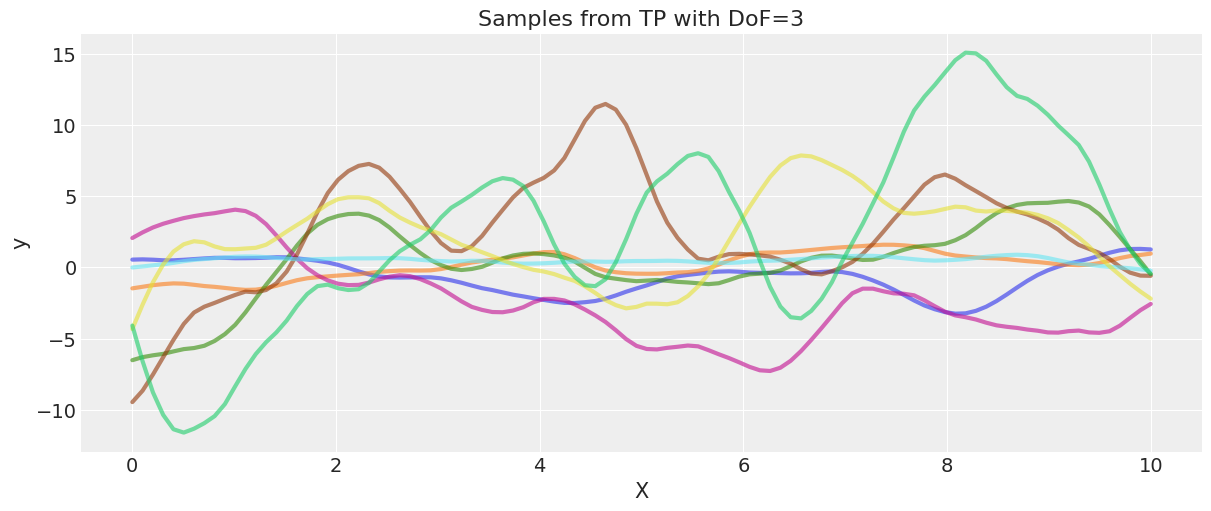

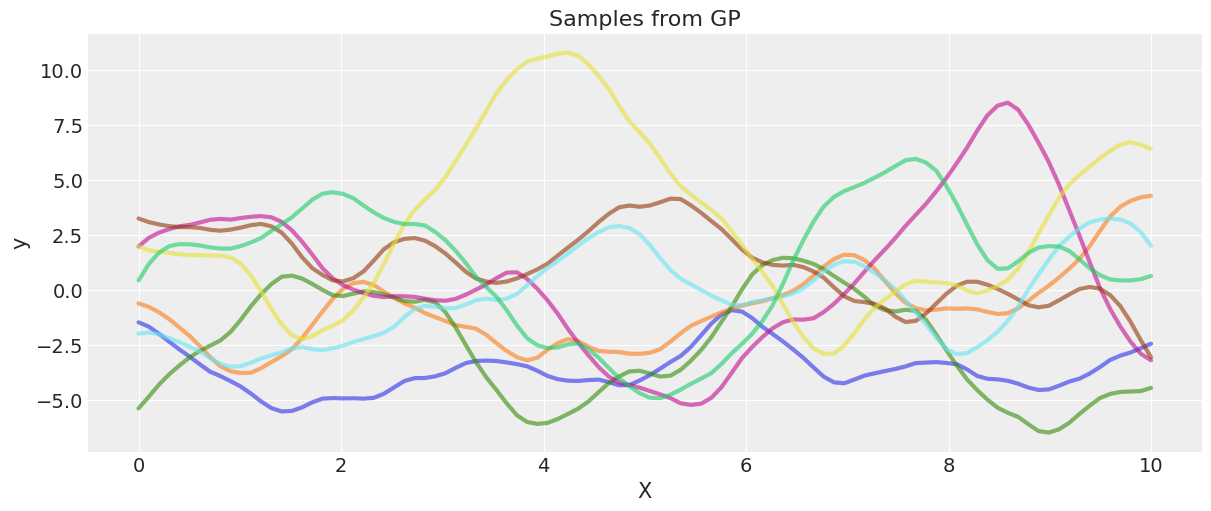

In [3]:
# set the seed
np.random.seed(1)

n = 100  # The number of data points
X = np.linspace(0, 10, n)[:, None]  # The inputs to the GP, they must be arranged as a column vector

# Define the true covariance function and its parameters
ℓ_true = 1.0
η_true = 3.0
cov_func = η_true ** 2 * pm.gp.cov.Matern52(1, ℓ_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC3 built on top of Theano
tp_samples = pm.MvStudentT.dist(mu=mean_func(X).eval(), cov=cov_func(X).eval(), nu=3).random(size=8)

## Plot samples from TP prior
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
ax.plot(X.flatten(), tp_samples.T, lw=3, alpha=0.6)
ax.set_xlabel("X")
ax.set_ylabel("y")
ax.set_title("Samples from TP with DoF=3")


gp_samples = pm.MvNormal.dist(mu=mean_func(X).eval(), cov=cov_func(X).eval()).random(size=8)
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
ax.plot(X.flatten(), gp_samples.T, lw=3, alpha=0.6)
ax.set_xlabel("X")
ax.set_ylabel("y")
ax.set_title("Samples from GP");

## Poisson data generated by a T process

For the Poisson rate, we take the square of the function represented by the T process prior.

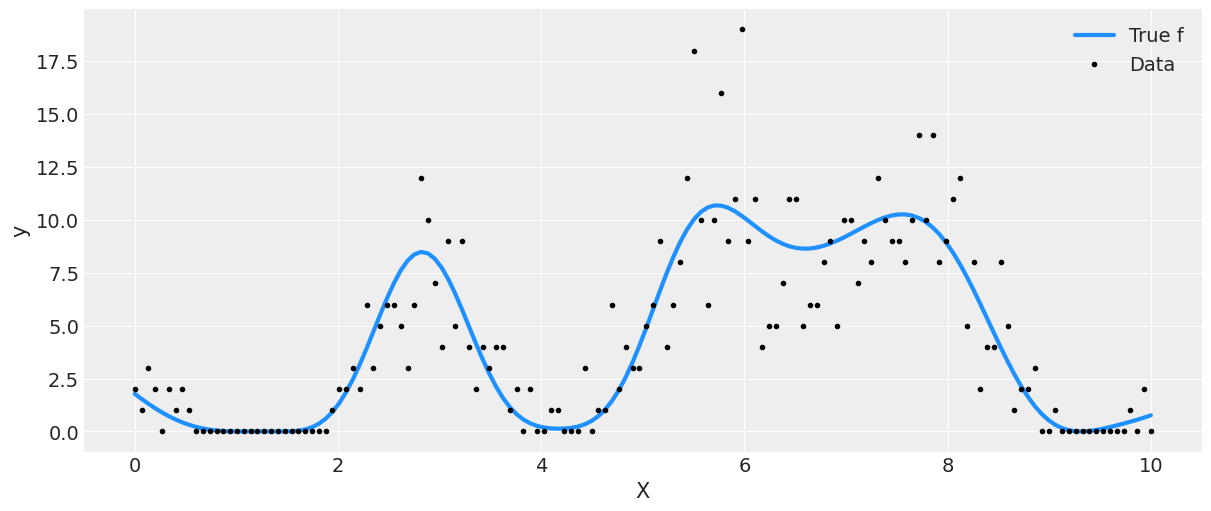

In [4]:
np.random.seed(7)

n = 150  # The number of data points
X = np.linspace(0, 10, n)[:, None]  # The inputs to the GP, they must be arranged as a column vector

# Define the true covariance function and its parameters
ℓ_true = 1.0
η_true = 3.0
cov_func = η_true ** 2 * pm.gp.cov.ExpQuad(1, ℓ_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC3 built on top of Theano
f_true = pm.MvStudentT.dist(mu=mean_func(X).eval(), cov=cov_func(X).eval(), nu=3).random(size=1)
y = np.random.poisson(f_true ** 2)

fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
ax.plot(X, f_true ** 2, "dodgerblue", lw=3, label="True f")
ax.plot(X, y, "ok", ms=3, label="Data")
ax.set_xlabel("X")
ax.set_ylabel("y")
plt.legend();

In [5]:
with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=2)
    η = pm.HalfCauchy("η", beta=3)
    cov = η ** 2 * pm.gp.cov.ExpQuad(1, ℓ)

    # informative prior on degrees of freedom < 5
    ν = pm.Gamma("ν", alpha=2, beta=1)
    tp = pm.gp.TP(cov_func=cov, nu=ν)
    f = tp.prior("f", X=X)

    # adding a small constant seems to help with numerical stability here
    y_ = pm.Poisson("y", mu=tt.square(f) + 1e-6, observed=y)

    tr = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/marco/miniconda/envs/pymc3-dev/lib/python3.8/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/marco/miniconda/envs/pymc3-dev/lib/python3.8/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/marco/miniconda/envs/pymc3-dev/lib/python3.8/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequenc

/home/marco/miniconda/envs/pymc3-dev/lib/python3.8/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/marco/miniconda/envs/pymc3-dev/lib/python3.8/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/marco/miniconda/envs/pymc3-dev/lib/python3.8/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead

/home/marco/miniconda/envs/pymc3-dev/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


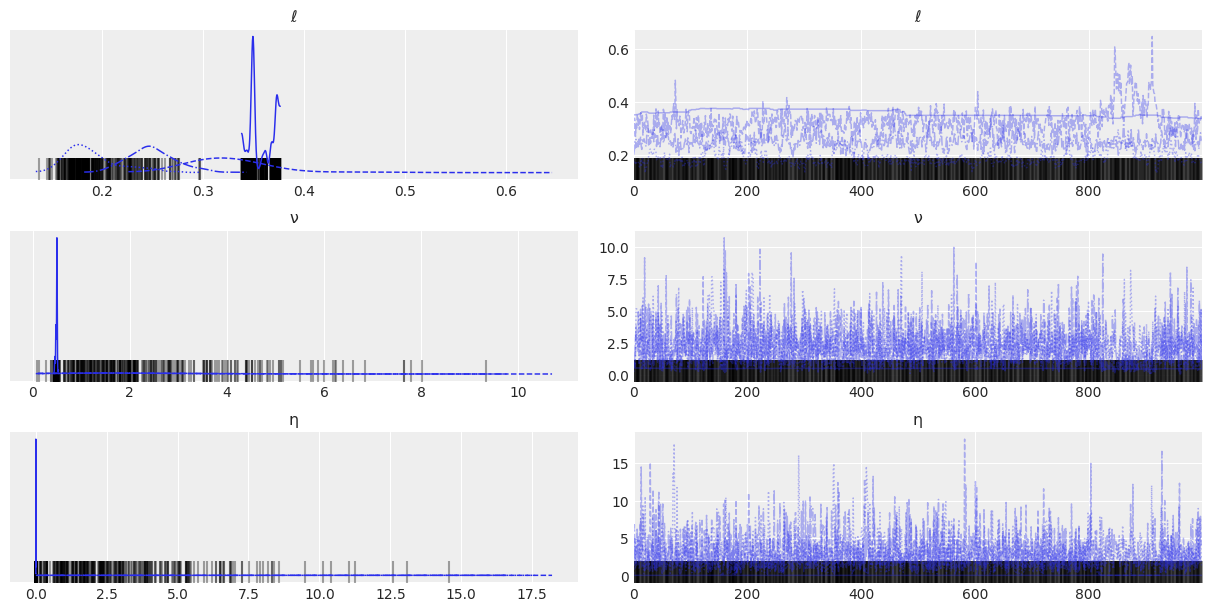

In [6]:
pm.traceplot(tr, var_names=["ℓ", "ν", "η"]);

In [7]:
n_new = 200
X_new = np.linspace(0, 15, n_new)[:, None]

# add the GP conditional to the model, given the new X values
with model:
    f_pred = tp.conditional("f_pred", X_new)

# Sample from the GP conditional distribution
with model:
    pred_samples = pm.sample_posterior_predictive(tr, vars=[f_pred], samples=1000)

/home/marco/pymc3-dev/pymc3/sampling.py:1688: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


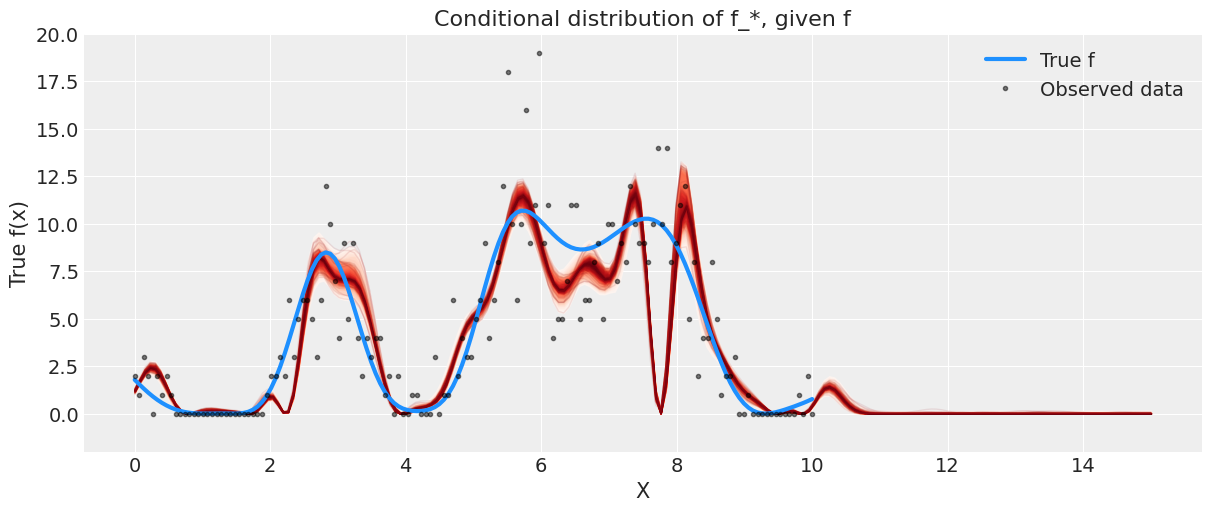

In [8]:
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, np.square(pred_samples["f_pred"]), X_new)
plt.plot(X, np.square(f_true), "dodgerblue", lw=3, label="True f")
plt.plot(X, y, "ok", ms=3, alpha=0.5, label="Observed data")
plt.xlabel("X")
plt.ylabel("True f(x)")
plt.ylim([-2, 20])
plt.title("Conditional distribution of f_*, given f")
plt.legend();

In [9]:
%load_ext watermark
%watermark -n -u -v -iv -w

numpy 1.19.1
arviz 0.9.0
pymc3 3.9.3
last updated: Sun Oct 18 2020 

CPython 3.8.5
IPython 7.18.1
watermark 2.0.2
